# Tutorial X: Basic DNA Sequence Analysis

© 2020 Griffin Chure, Soichi Hirokawa and Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT)  

--- 


In [1]:
import io # To be able to read strings as files
import string # To extract a list of lowercase letters
import numpy as np
import pandas as pd

# Import Biopython for file I/O.
import Bio.SeqIO
import Bio.AlignIO
import Bio.Phylo

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In this tutorial, we'll cover some basics of using Python to read data from a file into memory and how to examine the dispersal patterns of a famous reptile by looking at the sequence of its mitochondrial DNA. 

##  The curious case of *Mabuya atlantica*

Approximately 200 miles off the coast of Brazil exists a small (and quite beautiful) archipelago named [Fernando de Noronha](https://en.wikipedia.org/wiki/Fernando_de_Noronha). The twenty one islands and islets of this archipelago are volcanic in origin and have many endemic plant and animal species. One curious inhabitant of the archipelago is [*Mabuya atlantica*](https://en.wikipedia.org/wiki/Noronha_skink) (also known as the Noronha skink), which is phylogenetically placed along with the African species of *Trachylepis*. Because the archipelago was formed from volcanoes, there was no way that these lizards traveled to the island by land. How did they arrive at the island? In 1888, Alfred Russel Wallace proposed that perhaps the skink arrived on the archipelago by floating on a raft of vegetation across the open ocean, although this trip was estimated to take around 150 days using the knowledge of the oceanic currents from Africa to South America, as is shown in the figure below. 

<center>
    <img src="currents.png" width="50%">
    </center>


While the exact trajectory of this 'improbable voyage' is still up for debate, the phylogenetic placement of this species is fairly certain. This placement was not performed through morphology but through DNA sequence analysis. In this tutorial, we will use the data from [S. Carranza and E. N. Arnold](http://www.tandfonline.com/doi/abs/10.1017/S1477200003001099?journalCode=tsab20) who sequenced a component of the mitochondrial DNA from a large variety of skinks across the world and from Fernando de Noronha. We will learn how to read in the DNA sequences and score them by the similarity of their sequence to test this hypothesis. 

##  Loading in sequences

Before we can do any sequence comparisons, we must first load the [sequences](http://www.rpgroup.caltech.edu/courses/bi1_2017/data/mabuya_atlantica.zip) from the two text files into our computer to do the analysis. To become familiar with the structure of these documents, let's take a look at them. We can use the shell command `head` to take a look at a small section of the head of the text file. To have access to various shell commands in the Jupyter notebook, we must first type an exclamation point (`!`).

In [3]:
# Look at the sequences from Fernando de Noronha
! head ../data/mabuya_atlantica/noronha_mabuya.txt

>Mabuya atlantica isolate 1, Fernando de Noronha
ttgtcttctaaataaagaccagtatgaacggctaaatgaggacaaacctgtctcttttaa
ctaatcagtgaaactgatctcccagtacaaaagctgggatacaaacataagacgagaaga
ccccgtggagcttaaaacaaaaccaccaatcca--c------gccctgg-accctggtgg
actgttttgagttggggcgacttcggaataaaaagaaacttccgagcacagaaccac-aa
attctaaccaaggccaacaagcctaagcata---taa-ctgacccggccc--acgccgat
caacgaaccaagttaccccggggataacagcgctatcttcttcaagagtccctatcaaca
agaaggtttacgacctcgatgttggatcaggacacccaaatggtgcagccgctattaaag
gttcgtttgttcaacgatt


This line should give the following output:

`>Mabuya atlantica isolate 1, Fernando de Noronha
ttgtcttctaaataaagaccagtatgaacggctaaatgaggacaaacctgtctcttttaa
ctaatcagtgaaactgatctcccagtacaaaagctgggatacaaacataagacgagaaga
ccccgtggagcttaaaacaaaaccaccaatcca--c------gccctgg-accctggtgg
actgttttgagttggggcgacttcggaataaaaagaaacttccgagcacagaaccac-aa
attctaaccaaggccaacaagcctaagcata---taa-ctgacccggccc--acgccgat
caacgaaccaagttaccccggggataacagcgctatcttcttcaagagtccctatcaaca
agaaggtttacgacctcgatgttggatcaggacacccaaatggtgcagccgctattaaag
gttcgtttgttcaacgatt`

We can see that the file begins with a carrot '`>`' followed by some information about that specific sample. This is a standard sequence format known as [FASTA format](https://en.wikipedia.org/wiki/FASTA_format). There are [many sequence storage types](https://www.genomatix.de/online_help/help/sequence_formats.html) used in modern sequence analysis and Biopython [is capable of reading many of them](http://biopython.org/wiki/SeqIO). We can also see from the description that the first sample is the first isolate from the island Fernando de Noronha. Below this line is the actual DNA sequence. This sequence is composed of `atgc` and '`-`'. The letters correspond to the base identity at that position while the dash '`-`' indicates an insertion or deletion when the sequences were aligned to each other (see [this wonderful blog post](http://bitesizebio.com/9445/the-beginners-guide-to-dna-sequence-alignment/) for a primer on DNA alignment). Rather than copying and pasting these sequences into our notebooks to actually do the comparison, we'll use the [popular bioinformatics package Biopython](biopython.org) to load in these sequences.

Biopython can be used to do a wide variety of operations on DNA sequences. We will be using it for one rather simple purpose $-$ to load the sequences into memory. To do so, we will need to open the file, tell Biopython to read the contents, and then close the file. We'll first load the sequence from Fernando de Noronha.

In [5]:
# Open the file with sequences from Fernando de Noronha
with open('../data/mabuya_atlantica/noronha_mabuya.txt', 'r') as seq:
    noronha_file = Bio.SeqIO.parse(seq, 'fasta')
    noronha_sequences = [record for record in noronha_file]

Let's take a second to cover the syntax line-by-line in the above code cell. 

1. We used a `with` statement to `open` our file for reading only (`'r'`) and assigned it to the variable `seq`.

2. Within the `with` block, we used Biopython's [SeqIO.parse](http://biopython.org/wiki/SeqIO) function to read the file. We specified the format as `'fasta'`. This function generates something called a `SeqRecord` iterator which contains the sequence and description for each entry in the file.

3. We separated each record in the `SeqRecord` iterator into a list by using a single line `for` loop. By putting this loop in brackets `[]`, we convert the output to a list.

Now, each entry in the `noronha_sequences` list has two **attributes**; the sequence (`.seq`) and the description (`.description`). Let's take a look at the sequence and description of the Noronha skink.

In [6]:
# Look at the sequence and description of the first isolate.
noronha_seq = noronha_sequences[0].seq
noronha_desc = noronha_sequences[0].description
print(noronha_seq)
print(noronha_desc)

ttgtcttctaaataaagaccagtatgaacggctaaatgaggacaaacctgtctcttttaactaatcagtgaaactgatctcccagtacaaaagctgggatacaaacataagacgagaagaccccgtggagcttaaaacaaaaccaccaatcca--c------gccctgg-accctggtggactgttttgagttggggcgacttcggaataaaaagaaacttccgagcacagaaccac-aaattctaaccaaggccaacaagcctaagcata---taa-ctgacccggccc--acgccgatcaacgaaccaagttaccccggggataacagcgctatcttcttcaagagtccctatcaacaagaaggtttacgacctcgatgttggatcaggacacccaaatggtgcagccgctattaaaggttcgtttgttcaacgatt
Mabuya atlantica isolate 1, Fernando de Noronha


Let's do this again with the skink sequences from other regions of the world.  

In [7]:
# Open the file with sequences from the rest of the world.
with open('../data/mabuya_atlantica/world_mabuya.txt', 'r') as seq:
    world_file = Bio.SeqIO.parse(seq, 'fasta')
    world_sequences = [record for record in world_file]

 Again, let's take a look at the sequence and description.

In [8]:
# Look at the sequence and description of a skink in Brazil
brazil_seq = world_sequences[0].seq
brazil_desc = world_sequences[0].description
print(brazil_seq)
print(brazil_desc)

TTGTCTTTTAAATAAAGACCTGTATGAATGGCTGAATGAGGATAAACCTGTCTCTTATAACTAATCAGTGAAACTGATCTCCCAGTACAAAAGCTGGAATATACACATAAGACGAGAAGACCCTGTGGAGCTTAAAAC-AAACCACTAAACAA-----GT--ATACCACTACCTTAGTGTAC-GTTTTCAGTTGGGGCGACTTCGGAATAAAATGAAACTTCCGAGCACAGAGGCAC-TTCCTCTAACTAAGGCCAACAAGCCAAAGACCC---ATAAACGACCCGGCC---TTGCCGATCAACGAACCAAGTTACCCCAGGGATAACAGCGCAATCTTCTTCGAGAGCCCTTATCAACAAGAAGGTTTACGACCTCGATGTTGGATCAGGACACCCAAATGGTGCAGCCGCTATTAAAGGTTCGTTTGTTCAACGATT
Mabuya agilis, SW Brazil; Mato Grosso do Sul


We see again that we have the DNA sequence (although this one is upper case) and its description (`Mabuya agilis, SW Brazil; Mato Grosso do Sul`). Now that we know how to load and store the sequence information from a file, let's take a look at how to actually perform sequence comparison. 

## Computing a similarity score 

We'll compare the sequences from our skink on Fernando de Noronha to those in other regions of the world. To do so, we'll simplify our analysis to only compare the number of mismatches at a given position in the sequence. This means that we will have to ignore any gaps in the sequence (denoted by '`-`' signifying an insertion or deletion in the reference genome). How do we define what is 'similar'? There are [myriad ways of scoring sequence similarity](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3820096/) and is a subject that people have thought very deeply about. To whet our appetite for sequence analysis, we will simply compute what percentage of the base pairs we compared are identical to each other. By this definition, organisms with a larger percent similarity are more similar to each other than those with a lower percent similarity. 

Programmatically, how do we compute this? Remember from the [Python syntax tutorial](t0c_python_syntax_and_plotting.html) we can index letters in a string much like we can numbers in an array or items of a list. To perform the comparison, we'll simply iterate over each position in a sequence and ask two questions:

1. Is this position in either sequence a gap '`-`'? If so, we'll skip it and move to the next position.

2. Is this position in sequence 1 the same in sequence 2? If so, we'll count that as a similarity and move on. Note that by this definition, the two bases must be the **same letter** and in the **same case**. This means we will have to convert our `brazil_seq` to lowercase before we perform the comparison.

Before we begin the loop, we will need to make sure that the two sequences are the same length.

In [9]:
# Determine the length of the two sequences and make sure they are the same.
noronha_length = len(noronha_seq)
brazil_length = len(brazil_seq)
compared_length = (noronha_length == brazil_length)  # Should be True
print('Our sequences are the same length: ' + str(compared_length))

Our sequences are the same length: True


Great! Now, we can go ahead and set up a `for` loop to compare our two example sequences. 

In [10]:
# Convert the Brazil sequence to lowercase.
brazil_seq = brazil_seq.lower()

# Set up a counter to keep track of how many bases are identical.
num_sim = 0

# Set up a counter to keep track of how many positions we've compared.
comp_length = 0

# Iterate through each position in the sequences and compare.
for base in range(brazil_length):
    
    # Make sure we are not comparing a gap.
    if (noronha_seq[base] != '-') and (brazil_seq[base] != '-'):
        
        # Add one position to our counter of the comparison length.
        comp_length += 1   # Note this is same as comp_length = comp_length + 1
       
        # Compare the position and each sequence.
        if noronha_seq[base] == brazil_seq[base]:
            
            # If they are the same, add that to our counter.
            num_sim += 1
            
# Now compute the percent similarity and print it.
score = num_sim / comp_length
print(score)

0.8878281622911695


Our analysis tells us that our sequences are approximately 89% similar. This makes some intuitive sense considering that Fernando de Noronha is only about 200 miles away from the coast of mainland Brazil. However, we have a few other sequences to analyze before we can come to a conclusion regarding their dispersal. Let's take a look at the two other localities (South Africa and Turkey) in our `world_mabuya.txt` file. We could type everything again by hand, but this would be a wonderful opportunity to write a **function**. 

Our function will do the following operations with two provided sequences, `seq_1` and `seq_2`.

1. Ensure that `seq_1` and `seq_2` are the same length. If not, it will produce an error. For this, we'll include a `raise` statement with the `ValueError` exception.

2. Convert both sequences to lowercase and iterate through each sequence and compare every position that is not a gap in either sequence. 

3. Complete and return the percent similarity between the two sequences.


Let's give it a shot. 

In [11]:
def compute_similarity(seq_1, seq_2):
    """
    Computes the percent similarity between two sequences ignoring gaps. 
    
    Parameters
    ----------
    seq_1, seq_2 : strings
        DNA sequences to compare. These must be the same length.
        
    Returns
    -------
    score : float
        The percent similarity between the two sequences. 
    """
    # Make sure they are the same length. 
    if len(seq_1) != len(seq_2):
        raise ValueError('Sequences must be the same length!')
        
    # Make both sequences lowercase.
    seq_1 = seq_1.lower()
    seq_2 = seq_2.lower()
        
    # Set up counters of length and similarity.
    comp_length = 0
    num_sim = 0
    
    # Iterate through each position in the sequences.
    for base in range(len(seq_1)):
        
        # Ensure we are not comparing gaps.
        if (seq_1[base] != '-') and (seq_2[base] != '-'):
            
            # Increase the counter for compared length.
            comp_length += 1
            
            # Compare the two positions.
            if seq_1[base] == seq_2[base]:
                
                # Increase the similarity counter.
                num_sim += 1
                
    # Compute and return the percent similarity.
    score = num_sim  / comp_length
    return score
    

To check our function, let's feed it the two sequences we've worked with for this entire tutorial. It should return a similarity of 0.8878. 

In [12]:
# Test the function on our example sequences
function_score = compute_similarity(noronha_seq, brazil_seq)
print(function_score)

0.8878281622911695


Now, let's check that it fails when we give the function different sequences. 

In [13]:
# Generate sequences of dissimilar length.
seq_1 = 'aTtAcg-a'
seq_2 = 'ttac'

# Run these through the function. This should give an error.
failed_score = compute_similarity(seq_1, seq_2)

ValueError: Sequences must be the same length!

Great! Now that we are confident that our function works as advertised, let's compare the three other localities to Fernando de Noronha. Rather than doing this over three separate times, we can throw it in a `for` loop.

In [14]:
# Loop through the three other localities and print the result to the screen.
for locale in world_sequences:
    
    # Compute the similarity.
    score = compute_similarity(noronha_seq, locale.seq)
    
    # Print the locality and the score.
    print(locale.description, ': Score = ' + str(score))

Mabuya agilis, SW Brazil; Mato Grosso do Sul : Score = 0.8878281622911695
Mabuya capensis, South Africa; Kuga Mts. E. Cape : Score = 0.9304556354916067
Mabuya vittata, Turkey; Osmandere : Score = 0.9049881235154394


It looks like the skink from Brazil is actually the *least* similar of the three locales we examined. These data are suggestive that the skinks of Fernando de Noronha arrived from somewhere on mainland Africa! 

---
# Building a phylogenetic tree.

Given what we have learned so far about the use of molecular phylogenies to gain insight into the relationship between organisms we will now use this part of the tutorial to build a phylogenetic tree given these sequences.

There are several packages to work with phylogenies on Python, the most populars being [`Bio.Phylo`](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-13-209), [`DendroPy`](https://www.dendropy.org) and [`ETE`](http://etetoolkit.org). Each of them with their own advantages and disadvantages. But rather than teaching you how to use these powerful **black boxes** in this tutorial we will focus in coding our own phylogenetic tree program. Specifically we will implement the [*Neighbor Joining*](https://en.wikipedia.org/wiki/Neighbor_joining#NJ_with_5_taxa) algorithm.

The first thing we need to do is to import a sequence alignment with all 4 species of skinks. The difference between this alignment and the previous ones is that this file contains all 4 species, and the names of the species are only indicated as the country from which the sample was obtained. This will allow us to display the tree more easily.

Let's then use the `Bio.AlignIO` module to read the alignment in which is saved in `fasta` format.

In [29]:
# Read alignment with all species
aln = Bio.AlignIO.read('../data/mabuya_atlantica/mabuya_aln.fasta', 'fasta')
# PRint alignment
print(aln)

SingleLetterAlphabet() alignment with 4 rows and 439 columns
ttgtcttctaaataaagaccagtatgaacggctaaatgaggaca...att Fernando_de_Noronha
TTGTCTTTTAAATAAAGACCTGTATGAATGGCTGAATGAGGATA...ATT SW_Brazil
TTGTCTTCTAAATAAAGACCAGTATGAACGGCTAAATGAGGACA...ATT South_Africa
TTGTCTTCTAAATAAAGACCTGTATGAACGGCTAAATGAGGATA...ATT Turkey


## The Neighbor-Joining algorithm.

As described in the original [1987 paper](https://watermark.silverchair.com/7sait.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAbAwggGsBgkqhkiG9w0BBwagggGdMIIBmQIBADCCAZIGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQM5WHbpNhoFc3bvruMAgEQgIIBY3_ICLdGO26dKo_XZme-TKSrZWW78e1nyGQQdq_NkM8idfte2ObheJCQhIDXRAS6slPlk_PHn5P8f_tknOVbQPcPQqXjNqIqaLOCE3en7iCmCglLvT2OFcXvwkTDR0NsRHVDTcZAEtACIiklk_q7T-GUXiX6xj4lEiMdSL-CZD7H9Cns9mW_WqiJvexKL68l-0aN8aRySSR3Qm1WphVrUUDkfAC1fdNn8rRpI6B6XQep0qrDnRYcNIZILrpH31xEsbKJe9IvOIzaZAvw3gsO45JJ-uptXtPOvnWTLky2jBrI6M_gMsNpeZwhtFwdHTM_f-bpm2uuIAsu5uzLLSwQj4GaZXTAIGVVYXbAlwaXFmuaGzjIfkfsl9deGgsNgEOnCyHbQTWg0i-9tsKfyY6LaGmK9965-CtONZHbiKxNTt9ppVbtyCmGdm6xMRdHr-8Fm3vLnRSYmeR1Gqj50yGs4nkdMGc)
> The principle of this method is to find pairs of operational taxonomic units (OTUs [=neighbors]) that minimize the total branch length at each stage of clustering of OTUs starting with a starlike tree.

The following schematic describes the tree construction process.

<center>
<img src="nj_algorithm.png" width="20%">
</center>


The algorithm starts assuming no hierarchy in the structure of the tree (the starlike tree). Using as an input the pairwise distance between the nodes, the algorithm iteratively finds the two closest nodes and joins them to generate a new parental node (like node $u$ in the second schematic). It repeats this process, updating the distance metric as the number of unmatched nodes decreases. Once two nodes are joined with one another they cease to exist for the algorithm. It is only via the newly created parental node that these nodes can be connected to the rest of the tree.

### So how does the algorithm work?

The algorithm starts with a starlike topology like the one shown in panel (a) of the next figure taken from the original paper. All $N=8$ nodes are connected to a single interior node $X$. In practice some pairs of taxa, or more properly OTUs are more related to each other than other pairs. Assume for example that as in panel (b) nodes $1-2$ are more closely related. The algorithm then creates a new internal node $Y$ that connects the joined pair $1-2$ to the rest of the nodes.

<center>
   <img src="nj_construction.png" width="30%">
</center>

Let also $D_{ij}$ be the distance metric between OTUs $i$ and $j$ (for example our sequnce similarity metric could serve as a distance metric). The relationship between the branch length $L_{ab}$ and the distance $D_{ij}$ is as follows: Imagine that we know the distance $D_{13}$; for schematic (a) that is related to the branch length as
$$
D_{13} = L_{1X} + L_{3X},
\tag{1}
$$
i.e. the total length of the branches that connect nodes $1$ and $3$. For schematic (b) that would therefore be given by
$$
D_{13} = L_{1X} + L_{XY} + L_{Y3}.
\tag{2}
$$

To compute the sum of the branch lengths for schematic (a) is then given by
$$
S_o = \sum_{i=1}^N L_{iX} = {1 \over N - 1} \sum_{i < j} D_{ij}.
\tag{3}
$$
This is because if we only have information about the distances and not the branch lengths when we add up all distances we find that we counted each brand $N - 1$ times. This is probably easier to see if we start writing the sum of all distances in terms of the length relationships as in Eq. (1):
\begin{align}
\sum_{i < j} D_{ij} &= D_{12} + D_{13} + \ldots + D_{23} + \ldots + D_{N-1\;N}\\
&= \overbrace{(L_{1X} + L_{2X})}^{D_{12}} + 
\overbrace{(L_{1X} + L_{3X})}^{D_{13}} + \ldots +
\overbrace{(L_{2X} + L_{3X})}^{D_{23}} + \ldots +
\overbrace{(L_{N-1\;X} + L_{NX})}^{D_{N-1\;N}}.
\tag{4}
\end{align}
From here you can see that each length term appears multiple times, $N-1$ to be precise. That is why we divide by $N-1$ to obtain the total branch length.

Now, how do we compute the branch length $L_{XY}$ of the topology in schematic (b) if we only know distance information of the leafs of the tree? In principle we could add all the paths between node $1$ and the rest of the $\{3, 4, \ldots, N\}$ nodes, as well as the paths between $2$ and the rest of the nodes, and then subtract the branch lengths that we don't care about, like the ones connecting $1X$, $2X$ and all the $\{3, 4, \ldots, N\}$ nodes connected to $Y$.

Adding all the paths between node $1$ and the rest of the nodes counts $N - 2$ times the unwanted $L_{1X}$ branch. The same happens with branch $L_{2X}$. We don't know the length of each of these individual branches, but we know from Eq. (1) that adding them gives
$$
L_{1X} + L_{2X} = D_{12}.
\tag{5}
$$
So subtracting $(N - 2) D_{12}$ eliminates the undesired branches $L_{1X}$ and $L_{2X}$ from our estimate of the branch $L_{XY}$. The same is true for the other nodes, when counting all trajectories between $1$ and $2$ to the rest of the nodes, each of the branches $L_{iY}$ with $i \in \{3,\ldots,N\}$ is counted $2$ times. 
That means that to subtract all these undesired branch counts we can use the distances $D_{ij}$ with $i < j \in \{3, \ldots, N \}$. From Eq. (3) we can compute those distances as
$$
\sum_{i=3}^N L_{iY} = {1 \over (N - 2) - 1} \sum_{3 \leq i < j} D_{ij},
\tag{6}
$$
and extract this quantity twice to remove the undesired branches touching node $Y$.

Finally the branch $L_{XY}$ is counted ${N - 2}$ times for the paths involving node $1$ and the same number for paths involving node $2$, for a total of $2 (N - 2)$ times. So we have to account for that. This results in a branch distance $L_{XY}$ of the form
$$
L_{XY} = \overbrace{{1 \over 2(N - 2)}}^{\text{overcount of $L_{XY}$}}
\times [
\overbrace{\sum_{k=3}^N (D_{1k} + D_{2K})}^{\text{paths between nodes 1 and 2 to the rest}}
- \overbrace{(N - 2)(L_{1X} + L_{2X})}^{\text{remove paths between 1 and 2 to $X$}}
- \overbrace{2 \sum_{i=3}^N L_{iY}}^{\text{remove paths between the rest of the nodes to $Y$}},
]
\tag{7}
$$
or using the definition of the branch lengths as given by Eq 5 and 6
$$
L_{XY} = {1 \over 2(N - 2)} \left[  
\sum_{k=3}^N (D_{1k} + D_{2K})
- (N - 2) D_{12}
- {2 \over N - 3} \sum_{3 \leq i < j} D_{ij}
\right].
\tag{8}
$$


Given this, we can compute the total branch length of the topology in schematic (b) by adding all branch lengths as
$$
S_{12} = (L_{1X} + L_{2X}) + L_{XY} + \sum_{i=3}^N L_{iY}.
\tag{9}
$$
If we substitute the definitions we have obtained so far for these branch lengths  we have
$$
S_{12} = {1 \over 2 (N - 2)} \sum_{k=3}^N (D_{1k} + D_{2k})
+ {1 \over 2} D_{12} + {1 \over N - 2} \sum_{3 \leq i < j} D_{ij}.
\tag{10}
$$
It can be shown that Eq. 10 is the sum of the least-squares estimates of branch lengths.

This total branch length $S_{12}$ depended on us assuming that nodes $1$ and $2$ were the closest OTUs. But we don't know a priori if this is true, so the algorithm must compute all possible $S_{ij}$ with $i < j \in \{1,\ldots,N\}$ and choose the pair $ij$ that minimizes the total length.

For the sake of the example let's assume that indeed the pair $1-2$ is the one that minimizes the total distance of a topology like the one in schematic (b). Once the algorithm joins these two nodes and creates the $Y$ node, nodes $1$ and $2$ cease to exist and they are replaced by node $X$. Then the distance metric between these joined OTUs represented by node $X$ to the rest of the nodes is given by
$$
D_{Xj} = {D_{1j} + D_{2j} \over 2} \;\; \text{for } 3 \leq j \leq N,
\tag{11}
$$
i.e. the average distance between both nodes in the newly formed OTU.

Just as we inferred the length of the $L_{XY}$ branch for Eq. 7 and 8 based only on knowing the distances between nodes, once we defined the new OTU that joins $1$ and $2$ the length of the branches that connect these nodes to $X$ can be estimated from knowing the distances. By using the fact that the distance $D_{12}$ contains these two branches $L_{1X}$ and $L_{2X}$ and that also the distance between these nodes and the rest $D_{1j}$ and $D_{2j}$ with $j \in \{ 3,\ldots,N\}$ also contains these distances we obtain the following equations for the branches lengths
$$
L_{1X} = {1 \over 2} \left[ D_{12} + 
{1 \over N - 2} \sum_{i=3}^N D_{1i} -
{1 \over N - 2} \sum_{j=3}^N D_{2j}
\right],
\tag{12}
$$
and
$$
L_{2X} = {1 \over 2} \left[ D_{12} + 
{1 \over N - 2} \sum_{i=3}^N D_{2i} -
{1 \over N - 2} \sum_{j=3}^N D_{1j}
\right].
\tag{13}
$$

# Implementing the algorithm

It looks like a lot of nasty sums, but in reality the algorithm is not that difficult to implement. The first thing that we need to do is to build the distance matrix that the algorithm will use. For this I propose we use our already written function that computes a similarity score between two sequences and generate a square symmetric matrix containing the pairwise comparison of all available species.

Since we need a *distance* metric, i.e. something that measures how far away are two sequences we will use 1 - our similarity score. This makes sense since the distance that we will obtain at the diagonal, i.e. one species vs. itself will be zero for this proposed metric.

Given what we know so far this should be pretty simple to implement!

In [30]:
# Initialize matrix to save similarity scores
sim_mat = np.zeros([len(aln), len(aln)])

# loop through species in aln
for i, sp1 in enumerate(aln):
    # Extract species 1 sequences
    seq_1 = sp1.seq
    # loop through species in aln
    for j, sp2 in enumerate(aln):
        # Extract species 2 sequences
        seq_2 = sp2.seq
        # Compute and save similarity score
        sim_mat[i, j] = 1 - compute_similarity(seq_1, seq_2)
        
print('Similarity matrix for all {:d} sequences:'.format(len(aln)))
print(sim_mat)

Similarity matrix for all 4 sequences:
[[0.         0.11217184 0.06954436 0.09501188]
 [0.11217184 0.         0.1253012  0.10287081]
 [0.06954436 0.1253012  0.         0.10336538]
 [0.09501188 0.10287081 0.10336538 0.        ]]


### 1. Computing the total length matrix $\bb{S}$

The next step in the algorithm  will be to compute the total distance $S_{ij}$ as implemented by Eq. 10. Let's define a function that returns a matrix $\bb{S}$ given a distance matrix $\bb{D}$ where each entry of $\bb{S}$ is given by  Eq. 10.b, i.e. $\bb{S}_{ij} = S_{ij}$.

In [31]:
def s_matrix(mat):
    '''
    Computes the S-Matrix for the Neighbor Joining algorithm. Each entry
    S_ij computes the total branch length assuming that nodes i and j form
    a new OTU.
    Parameters
    ----------
    mat : array-like. N x N matrix
        Square matrix containing similarity scores between OTUs
    Returns
    -------
    s_mat : array-like. N x N matrix
        Square matrix containing the total branch length when joining
        each possible pair of OTUs
    '''
    # Get the number of entries in matrix
    n = len(mat)
    
    # Compute the starlike length
    s_star = 1 / (n - 1) * np.sum(np.triu(mat))
    # Initialize matrix to save entries
    s_mat = np.ones_like(mat) * s_star

    # Loop through rows
    for i in range(n):
        # Loop through columns
        for j in range(n):
            # Define list of index different from i and j
            idx_out = np.arange(n)
            idx_out = np.delete(idx_out, [i, j])
            
            # To make the calculation simpler we will divide Eq. 3 into
            # the three terms
            # First term
            first_term = 1 / (2 * (n - 2)) * np.sum(mat[i, idx_out] + \
                                                    mat[j, idx_out])
            
            # Second term
            second_term = 1 / 2 * mat[i, j]
            
            # Third term
            # We have to be slightly clever for this one. To add all of the
            # terms that do not include either i or j we will eliminate
            # those columns from the matrix mat and we will use the function
            # np.triu to generate an upper triangular matrix with the lower
            # half of the matrix all zeros. That way when we add the entire
            # matrix we only sum the terms that didn't contain i or j
            reduced_mat = np.delete(mat, [i, j], axis=0)
            reduced_mat = np.delete(reduced_mat, [i, j], axis=1)
            third_term = 1 / (n - 2) * np.sum(np.triu(reduced_mat))
            
            # Add result to the s matrix
            s_mat[i, j] = first_term + second_term + third_term
            
    # Set all terms in diagonal to zero since we don't want the diagonal
    # to play any role in further steps
    np.fill_diagonal(s_mat, 0)
    
    return s_mat

Having implemented this function we can apply it to our distance matrix

In [32]:
s_mat = s_matrix(sim_mat)
print('Total branch length difference with respect to starlike topology')
print(s_mat)

Total branch length difference with respect to starlike topology
[[0.         0.20595068 0.19517016 0.20714464]
 [0.20595068 0.         0.20714464 0.19517016]
 [0.19517016 0.20714464 0.         0.20595068]
 [0.20714464 0.19517016 0.20595068 0.        ]]


### 3. Finding the entry with the smallest distance

Now that we computed the matrix let's find out which of the OTU pairs minimizes the total branch length. We will do that with the help of the function `np.where`. Note that the diagonal is never an option to choose, so our selection should be based on non-diagonal or non-zero terms.

In [33]:
# Find the minimum non-zero entry
min_val = np.min(s_mat[np.nonzero(s_mat)])
# Find where the minimum distance is
row, col = np.where(s_mat == min_val)

# Choose the smaller index as the row and the large index as the column
idx = [row[0], col[0]]
i, j = min(idx), max(idx)

# Extract species index (numeric position)
i, j = row[0], col[0]
print('OTU pair : {0:d},{1:d}'.format(i, j))

OTU pair : 0,2


That means that for our example species index 0 and index 2 are the closest neighbors. So we will join them into a single OTU.

### 4. Add new node to the matrix and update distance metric.

Now that we will generate a new node (0-2) that joins the closest OTUs we need to update our distance metric. We now need to compute the distance between this new node and the rest of the nodes, i.e. $D_{(0-2)j}$ for $j \neq {0, 2}$.

The way we will implement this will be as follows:
1. Add a new row to our matrix `sim_mat` and a new column to increase the number of rows and columns by 1.
2. Populate the entries of this new row and column with the distances as defined by Eq. 11 (in a symmetric way).
3. Eliminate the rows and columns corresponding to the two OTUs we are joining (0 and 2 for this example).

Let's follow this steps.

In [34]:
# 1. Add a new row to our matrix `sim_mat` and a new column to 
# increase the number of rows and columns by 1.
# first we generate a matrix full of zeros with one extra row and column
mat_plus = np.zeros(np.array(sim_mat.shape) + 1)
# Then we replace 0's with known distance
mat_plus[0:sim_mat.shape[0], 0:sim_mat.shape[1]] = sim_mat

# 2. Populate the entries of this new row and column with the distances 
# as defined by Eq. 11 (in a symmetric way).
for k in range(len(sim_mat)):
    mat_plus[k, -1] = (1 / 2) * (sim_mat[k, i] + sim_mat[k, j])
    mat_plus[-1, k] = mat_plus[k, -1]
    
# Eliminate the rows and columns corresponding to the two OTUs 
# we are joining (0 and 2 for this example).
mat_plus = np.delete(mat_plus, [i, j], axis=0)
mat_plus = np.delete(mat_plus, [i, j], axis=1)

print('The new distance matrix is given by')
print(mat_plus)

The new distance matrix is given by
[[0.         0.10287081 0.11873652]
 [0.10287081 0.         0.09918863]
 [0.11873652 0.09918863 0.        ]]


### 5. Saving joined OTU with distance and REPEAT

At this point all we have left for the algorithm to work is register the branch length between the two OTUs that we joined (0 and 2 for the example) and the new generated node (0-2). Then we have to repeat the procedure this time using the updated distance matrix.

# A tidy function 

We have implemented the algorithm in the following function. This implementation goes beyond what we saw in the sense that it not only generates the tree, but it keeps track of the newly formed nodes (using dictionaries and Pandas DataFrames) and generates a [newick string](https://en.wikipedia.org/wiki/Newick_format) that is a standard format for phylogenetic trees that biophyton can use to display the tree.

In [23]:
def neighbor_joining(D, names=None):
    '''
    test
    '''
    # Convert distance matrix to DataFrame to track index identity
    df_D = pd.DataFrame(D)
    
    # Save original index. This is important to distinguish internal nodes
    # from external ones.
    original_idx = df_D.index.tolist()
    
    # Get shape of distance matrix
    shape = D.shape
    
    # Check that the matrix is a square matrix
    if shape[0] != shape[1]:
        raise ValueError('The ditance matrix must be square')
    
    # Check that is is larger than 2 x 2
    if shape[0] == 2:
        raise ValueError('No work to do. The tree has only two nodes')
    
    # Check that the names given are the same length as the distrance matrix
    if names == None:
        names = string.ascii_lowercase[0:len(df_D)]
    elif len(names) != len(D):
        raise ValueError('Are you sure you gave me enough names?')
    
    # Initialize dictionary to save output tree in the format 
    # 'x->y:distance'
    tree = dict()
    
    # Initialize dictionary to save the distance between recently joined
    # nodes. This is necessary to determine branch length of internal nodes
    tree_nodes = dict()
    
    # Initialize dictionary to save node names to generate the newick format
    newick_dict = dict(zip(df_D.index.tolist(), names))
    
    # Start the algorighm
    for loop in range(shape[0] - 2):
        # extract numerical values of DataFrame
        D = df_D.values
        
        # Obtain size of distance matrix
        n = len(D)
        
        # Compute Q-matrix
        s_mat = s_matrix(D)
        
        # Find where the minimum distance is
        min_val = np.min(s_mat[np.nonzero(s_mat)])
        row, col = np.where(s_mat == min_val)
        idx = [row[0], col[0]]
        i, j = min(idx), max(idx)
        
        # Extract species index (index name)
        i_idx = df_D.iloc[i,:].name
        j_idx = df_D.iloc[j,:].name
        
        
        # Define list of index different from i and j
        idx_out = np.arange(n)
        idx_out = np.delete(idx_out, [i, j])
            
        # Compute distance of the recently joined edges
        limb_length_i = (1 / 2) * (D[i, j] + np.sum(D[i, idx_out]) / (n - 2)
                                           - np.sum(D[j, idx_out]) / (n - 2))
        limb_length_j = (1 / 2) * (D[i, j] + np.sum(D[j, idx_out]) / (n - 2)
                                           - np.sum(D[i, idx_out]) / (n - 2))
        
        # Generate expanded matrix with extra row to update distances
        mat_plus = np.zeros(np.array(D.shape) + 1)
        # Replace 0's with known distance
        mat_plus[0:D.shape[0], 0:D.shape[1]] = D
        
        # Update distance to new node
        for k in range(len(D)):
            mat_plus[k, -1] = (D[k, i] + D[k, j]) / 2
            mat_plus[-1, k] = mat_plus[k, -1]
            
        # Define new node index
        m = max(df_D.index.tolist()) + 1
        # Extract index from current DataFrame
        new_idx = df_D.index.tolist() + [m]
        # Convert extended distance matrix to data frame using same index
        df_D = pd.DataFrame(mat_plus, index=new_idx, columns=new_idx)
        # Drop the rows and columns of the two nodes that were joined
        df_D.drop(index=[i_idx, j_idx], inplace=True)
        df_D.drop(columns=[i_idx, j_idx], inplace=True)
        
        # Save the distance between the two nodes being connected. Useful to
        # determine internal branch length
        tree_nodes[m] = D[i,j]
        
        # If the node is internal (i.e. it didn't existed in the origina list)
        # update the branch length by correcting using the distance between the
        # nodes that originally formed this node.
        if i_idx not in original_idx :
            limb_length_i = limb_length_i - tree_nodes[i_idx] / 2
        if j_idx not in original_idx :
            limb_length_j = limb_length_j - tree_nodes[j_idx] / 2
        
        # Add entry to tree
        tree[str(i_idx) + '->' + str(m)] = limb_length_i
        tree[str(j_idx) + '->' + str(m)] = limb_length_j
        
        tree[str(m) + '->' + str(i_idx)] = limb_length_i
        tree[str(m) + '->' + str(j_idx)] = limb_length_j
        
        # Newick format of this joined nodes
        name = '({0:s}:{2:0.2f}, {1:s}:{3:0.2f})'.\
               format(newick_dict[i_idx], newick_dict[j_idx],
                      limb_length_i, limb_length_j)
            
        # Append name to newick_dict
        newick_dict[m] = name
        
    # Extract last two nodes to be joined
    last_idx = df_D.index.tolist()
    last_corr = min([tree_nodes[x] for x in last_idx])
    # Extract last distance
    last_dist = (1 / 2) * df_D.iloc[1, 0] - last_corr / 2
    
    # Append the distance of the last two-knobs left
    tree[str(last_idx[0]) + '->' + str(last_idx[1])] = last_dist
    tree[str(last_idx[1]) + '->' + str(last_idx[0])] = last_dist
    
    newick_str = '({0:s}:{2:0.2f}, {1:s}:{3:0.2f})'.\
               format(newick_dict[last_idx[0]], newick_dict[last_idx[1]],
                      last_dist, last_dist)
    
    return tree, newick_str

Now that we have the function let's use it with our data!

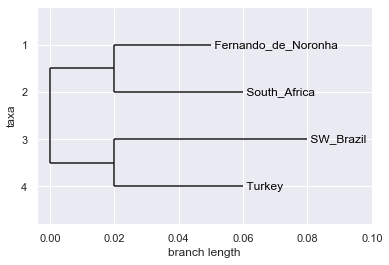

In [24]:
species_names = [sp.name for sp in aln]
tree_dict, newick = neighbor_joining(sim_mat, species_names)
tree = Bio.Phylo.read(io.StringIO(newick), 'newick')
Bio.Phylo.draw(tree)

Just to double check that this algorithm is indeed giving the right answer we will copy the example distance matrix from the [wiki entry](https://en.wikipedia.org/wiki/Neighbor_joining) of the algorithm and see if we obtain the same tree as the one they propose.

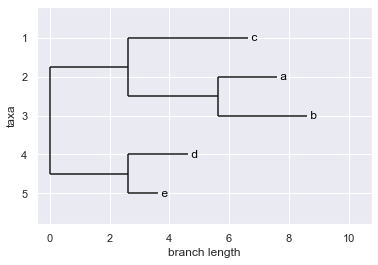

In [25]:
D = np.array([[0, 5, 9, 9, 8],
              [5, 0, 10, 10, 9],
              [9, 10, 0, 8, 7],
              [9, 10, 8, 0, 3],
              [8, 9, 7, 3, 0]])
tree_dict, newick = neighbor_joining(D)
tree = Bio.Phylo.read(io.StringIO(newick), 'newick')
Bio.Phylo.draw(tree)

---
# Working implementation (Different from paper)
---

An alternative implementation of the algorithm is proposed in [this entry](http://rosalind.info/problems/ba7e/) from the Rosalind Bioinformatics course website. The steps of the algorithm are also described (**but not justified!**) in the [Wiki entry](https://en.wikipedia.org/wiki/Neighbor_joining#The_algorithm) as:
1. Based on the current distance matrix $\bb{D}$ calculate the matrix $\bb{Q}$ (to be defined later).
2. Finde the pair of distinct taxa $i-j$ with $i \neq j$ for which $\bb{Q}_{ij}$ has its lowest value.
3. Calculate the distance from each of the taxa in the $i-j$ pair to the newly formed node.
4. Calculate the distance from each of the taxa outside of the $i-j$ pair to this new node.
5. Start the algorithm again, replacing the pair of joined neighbors with the new node, and using the updated distance matrix $\bb{D}'$.

Again your nice TA implemented this for you to have an alternative to the original 1987 implementation that also works.

In [26]:
def q_matrix(mat):
    '''
    Computes the Q-Matrix for the Neighbor Joining algorithm
    '''
    # Get the number of entries in matrix
    n = len(mat)
    
    # Initialize matrix to save entries
    q_mat = np.zeros_like(mat)

    # Loop through rows
    for i in range(n):
        for j in range(n):
            q_mat[i, j] = (n - 2) * mat[i, j] - \
                          np.sum(mat[i, :]) - \
                          np.sum(mat[j, :])
    np.fill_diagonal(q_mat, 0)
    
    return q_mat

In [27]:
def neighbor_joining_alternative(D, names=None):
    '''
    test
    '''
    # Convert distance matrix to DataFrame to track index identity
    df_D = pd.DataFrame(D)
    
    # Get shape of distance matrix
    shape = D.shape
    
    # Check that the matrix is a square matrix
    if shape[0] != shape[1]:
        raise ValueError('The ditance matrix must be square')
    
    # Check that is is larger than 2 x 2
    if shape[0] == 2:
        raise ValueError('No work to do. The tree has only two nodes')
    
    # Check that the names given are the same length as the distrance matrix
    if names == None:
        names = string.ascii_lowercase[0:len(df_D)]
    elif len(names) != len(D):
        raise ValueError('Are you sure you gave me enough names?')
    
    # Initialize dictionary to save output tree
    tree = dict()
    
    # Initialize dictionary to save node names to generate the newick format
    newick_dict = dict(zip(df_D.index.tolist(), names))
    
    # Start the algorighm
    for loop in range(shape[0] - 2):
        # extract numerical values of DataFrame
        D = df_D.values
        
        # Obtain size of distance matrix
        n = len(D)
        
        # Compute Q-matrix
        q_mat = q_matrix(D)
        
        # Find where the minimum distance is
        row, col = np.where(q_mat == q_mat.min())
        
        # Extract species index (numeric position)
        i, j = row[0], col[0]
        # Extract species index (index name)
        i_idx = df_D.iloc[i,:].name
        j_idx = df_D.iloc[j,:].name
        
        # Compute distance ∆
        delta_dist = np.sum(D[i, :] - D[j, :]) / (n - 2)
        
        # Compute distance of the recently joined edges
        limb_length_i = (1 / 2) * (D[i, j] + delta_dist)
        limb_length_j = (1 / 2) * (D[i, j] - delta_dist)
        
        # Generate expanded matrix with extra row to update distances
        mat_plus = np.zeros(np.array(D.shape) + 1)
        # Replace 0's with known distance
        mat_plus[0:D.shape[0], 0:D.shape[1]] = D
        
        # Update distance to new node
        for k in range(len(D)):
            mat_plus[k, -1] = (1 / 2) * (D[k, i] + D[k, j] - D[i, j])
            mat_plus[-1, k] = mat_plus[k, -1]
            
        # Define new node index
        m = max(df_D.index.tolist()) + 1
        # Extract index from current DataFrame
        new_idx = df_D.index.tolist() + [m]
        # Convert extended distance matrix to data frame using same index
        df_D = pd.DataFrame(mat_plus, index=new_idx, columns=new_idx)
        # Drop the rows and columns of the two nodes that were joined
        df_D.drop(index=[i_idx, j_idx], inplace=True)
        df_D.drop(columns=[i_idx, j_idx], inplace=True)
        
        # Add entry to tree
        tree[str(i_idx) + '->' + str(m)] = limb_length_i
        tree[str(j_idx) + '->' + str(m)] = limb_length_j
        
        tree[str(m) + '->' + str(i_idx)] = limb_length_i
        tree[str(m) + '->' + str(j_idx)] = limb_length_j
        
        # Newick format of this joined nodes
        name = '({0:s}:{2:0.2f}, {1:s}:{3:0.2f})'.\
               format(newick_dict[i_idx], newick_dict[j_idx],
                      limb_length_i, limb_length_j)
        # Append name to newick_dict
        newick_dict[m] = name
        
    # Extract last two knobs to be joined
    last_idx = df_D.index.tolist()
    # Extract last distance
    last_dist = df_D.iloc[1, 0]
    
    # Append the distance of the last two-knobs left
    tree[str(last_idx[0]) + '->' + str(last_idx[1])] = last_dist
    tree[str(last_idx[1]) + '->' + str(last_idx[0])] = last_dist
    
    newick_str = '({0:s}:{2:0.2f}, {1:s}:{3:0.2f})'.\
               format(newick_dict[last_idx[0]], newick_dict[last_idx[1]],
                      last_dist, last_dist)
    
    return tree, newick_str

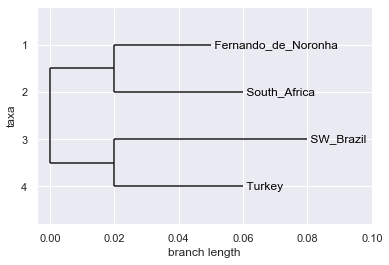

In [28]:
species_names = [record.name for record in aln]
tree_dict, tree_newick = neighbor_joining_alternative(sim_mat, 
                                                      names=species_names)
newick = Bio.Phylo.read(io.StringIO(tree_newick), 'newick')
Bio.Phylo.draw(newick)

# In conclusion

We learned the basics of how to compare sequences and how to use these comparison metrics to generate a phylogenetic tree. There are still a couple of details to clarify from the algorithm implementation, but we definitely moved forward to shedding some light into the dark box that tree-generating algorithms usually are.